In [135]:
import pandas_datareader as pdr
import requests
import pandas as pd
from datetime import datetime, timedelta
import sqlite3 
import sql_tools
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pylab as plt
import seaborn as sea
pick = sql_tools.IcePick(sqlite3, 'trade_history.sqlite')
con = sqlite3.connect('trade_history.sqlite')
phi = (1 + np.sqrt(5))/2

In [2]:
def download_data(ticker, *args, **kwargs):
    i = 0
    while True:
        try:
            print('Trying to Download: {}'.format(ticker))
            data = pdr.DataReader(ticker, 'yahoo', *args, **kwargs)
            return data
        except pdr.base.RemoteDataError as e:
            i = i + 1
            print(e)
            print('Error {} : Exponential Backoff time: {}'.format(i , i**2))
            
            if i > 7:
                print('Error Got too big, raising it')
                raise e 
            time.sleep(i ** 2)
            
bar_pos = 0            
def progress_bar(i, left):
    
    global bar_pos
    bar_pos = bar_pos + 1
    power_of_one_dot = 100/left
    pos = int(power_of_one_dot * i)
    bar = ''

    for num in range(0, pos -1 ):
        if (num + bar_pos) %2 == 0:
            bar = bar + '-'
        if (num + bar_pos) %2 != 0:
            bar = bar + '🚃'             
    bar = bar + '🚢'
    for num in range(0, 100 - pos):
        bar = bar + ' '
    bar = '-' + bar
    bar = bar + '| {:.2f} % \nDone: {} Remaining: {}'.format(100 * i/(left -1), i, left - i )
    print(bar)



In [4]:
def download_tickers():
    nyse = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&render=download')
    nasdaq = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download')
    data = nyse.append(nasdaq)
    data['Symbol']= data['Symbol'].str.replace(' ', '')
    data = data.set_index('Symbol')
    data = data[~data.index.duplicated()]
    data = data[~data.index.str.contains('\^')]
    data = data[~data.index.str.contains('\.')]
    data = data[~data.index.str.contains('\~')]
    data = data[data['MarketCap'] > 0]
    del data['Unnamed: 9']
    data['table_name'] = '_'+ data.index + '_'
    return data
tickers = download_tickers()

def create_updates(tickers):
    updates = pd.DataFrame(index = set(tickers))
    updates['last_updated'] = datetime(2018,1,24)
    updates.index.name = 'ticker'
    updates.to_sql('tickers', con, if_exists='replace')
    

def save_timestamp(ticker, time):
    with pick.get_connection() as cur:
        sql = "CREATE TABLE IF NOT EXISTS tickers (id text primary key, ticker text, last_updated text);"
        cur.execute(sql)
        
    with pick.get_connection() as cur:
        sql = """
        INSERT OR REPLACE INTO tickers(id, ticker, last_updated)
        Values ('{}', '{}', '{}')
        """.format( '_' + ticker + '_', ticker, time)
        cur.execute(sql)
    return

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
def save_data(data, ticker = None, kind = ''):
    ''' kind must be one of:update, reset '''
    ok_types = ['update', 'reset']
    if kind not in ok_types:
        raise ValueError( ' argument kind must be one of the following: {}'.format(','.join(ok_types)))
    if (type(data) == pd.DataFrame) and (type(ticker) == type(None)):
        raise ValueError( 'Must Specify ticker argument with type = \'Dataframe\'')
    if type(data) == pd.core.panel.Panel:
        for ticker in data.minor_axis:
            candles = data.minor_xs(ticker)
            save_data(candles, ticker, kind)
            
    if type(data) == pd.DataFrame:
        _ticker_ = '_' + ticker + '_'
        data.columns = data.columns.str.replace(' ', '_')
        data = data.fillna("'nan'").replace('nan', "'nan'")
        if kind == 'reset':
            with pick.get_connection() as con:
                sql = "DROP TABLE IF EXISTS {} ".format(_ticker_)
                con.execute(sql)
            with pick.get_connection() as con:    
                sql = """ create table {} (Date text primary key,
                Open real ,High real ,Low real ,
                Close real ,Adj_Close real, Volume real )""".format(_ticker_)
                con.execute(sql)
            kind = 'update'
            
        if kind == 'update':
            
            column_names = list([data.index.name]) + list(data.columns)
            sql = """ INSERT OR REPLACE INTO {}({})\nValues """.format(_ticker_,','.join(column_names) )
            value_bit = []
            for date in data.index:
                row = data.loc[date]
                others = ','.join(row.apply(str).values)
                value_bit.append( " ('{}', {} )".format(date, others))
            sql = sql + ',\n'.join(value_bit)
            with pick.get_connection() as con:
                con.execute(sql)
                con.commit()


        latest_date = data.index.max()
        save_timestamp(ticker, latest_date)
    return 
        

In [5]:
def update_tickers(to_date):
    t = pd.to_datetime
    to_date = t(t(to_date).strftime('%Y-%m-%d'))
    tables = pick.get_data('tickers')
    tables = tables.set_index('table_name')
    tables['last_updated'] = pd.to_datetime(tables['last_updated'])

    tables['need_update'] = tables['last_updated'] < to_date
    tables=  tables[tables['need_update']]
    
    i = 0
    batch_size = 10
    to_do_length = len(tables)
    for thing in batch(tables, batch_size):
        downloaded_data = download_data(thing.index)
        downloaded_data = pd.DataFrame()
        save_data(downloaded_data, kind = 'update')
        
        i = min(i + batch_size, to_do_length)
        progress_bar(i,to_do_length)
        clear_output(True)
        
    return tables
#x = update_tickers(datetime.today())

In [7]:
data = download_data('SBUX')

Trying to Download: SBUX


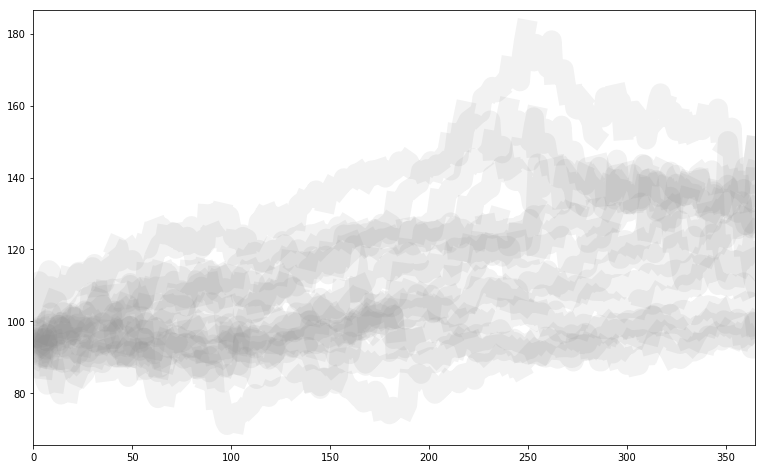

In [208]:
prices = pd.DataFrame()
i = 0

mask = data['Close'].pct_change() < -0.04
fig, ax = plt.subplots()
fig.set_size_inches(8 * phi, 8 )
for index in data[mask].index:
    start = index - timedelta(days = 1)
    end = start + timedelta(days = 365)
    x = data.loc[start: end]
    
    x.index = (x.index - x.index.min()).days
    
    x  = x['Close'].pct_change()
    x = x.dropna()
    current = 100
    final = pd.DataFrame(index = list(range(0, 366)))
    for day in x.index: 
        current = current * x[day] + current
        final.loc[day, 'vals'] = current        
    final['vals'].plot(ax = ax, alpha = 0.1, linewidth = 20, color = 'grey')
    prices[i] = final
    i = i + 1


plt.show()

In [209]:
prices = prices.ffill()
prices = prices.bfill()

In [210]:
current_price = data.loc[data.index.max()]['Close']

In [211]:
prices = (prices / 100)   * current_price


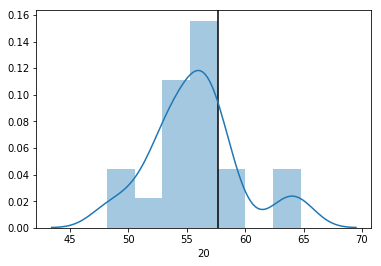

In [215]:
fig, ax = plt.subplots()
sea.distplot(prices.loc[20], ax = ax)
minimum, maximum = ax.get_ylim()
ax.vlines(current_price,minimum,maximum  )
plt.show()


C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


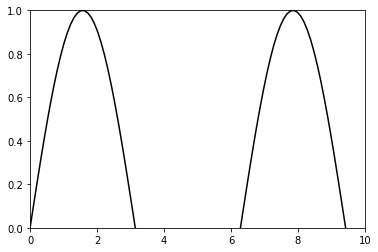

In [224]:
import matplotlib.animation as animation

x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 10, 0, 1])
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)
ani.save('test.html')
plt.show()

In [31]:
def similar(ticker,sector = True, industry = True , tickers = tickers  ):
    current = tickers.loc[ticker]
    mask = tickers['MarketCap'] > 0
    if sector:
        mask = mask & (tickers['Sector'] == current['Sector'])
    if industry:
        mask = mask & (tickers['Industry'] == current['Industry'])   
    return tickers[mask]

similar('SBUX').sort_values('MarketCap')

,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,table_name
Symbol,,,,,,,,,
BURG,"Chanticleer Holdings, Inc.",3.35,1.013590e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/burg,_BURG_
KONA,"Kona Grill, Inc.",1.65,1.667322e+07,n/a,2005,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/kona,_KONA_
GTIM,Good Times Restaurants Inc.,2.5,3.116810e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/gtim,_GTIM_
SAUC,"Diversified Restaurant Holdings, Inc.",1.6,4.301057e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/sauc,_SAUC_
BBRG,"Bravo Brio Restaurant Group, Inc.",2.95,4.485373e+07,n/a,2010,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/bbrg,_BBRG_
DAVE,"Famous Dave&#39;s of America, Inc.",6.1,4.499236e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/dave,_DAVE_
STKS,"The ONE Group Hospitality, Inc.",2.28,6.164338e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/stks,_STKS_
FAT,FAT Brands Inc.,8.8,8.800000e+07,n/a,2017,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/fat,_FAT_
ARKR,Ark Restaurants Corp.,25.6254,8.800226e+07,n/a,n/a,Consumer Services,Restaurants,http://www.nasdaq.com/symbol/arkr,_ARKR_
